In [1]:
import cv2
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from inference import *

from config import DBConfig
from models.dbnet import DBNet

### 1. DBNet 文本检测模型

In [3]:
db_cfg = DBConfig()

In [4]:
def show_img(img):
    plt.figure(figsize=(15, 7))
    plt.imshow(img)
    plt.show()

In [5]:
db_model = DBNet(db_cfg, model='inference')

In [6]:
db_model.load_weights(db_cfg.PRETRAINED_MODEL_PATH, by_name=True, skip_mismatch=True)

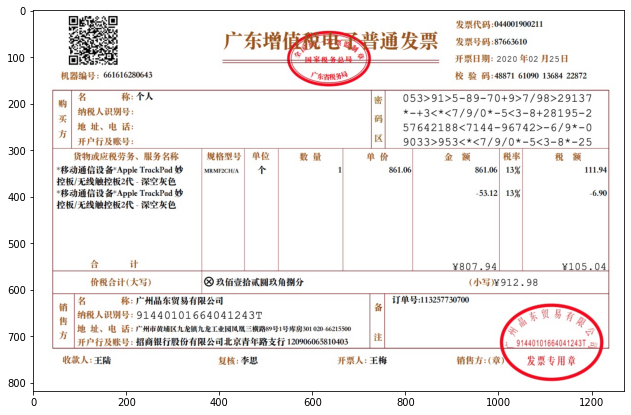

In [7]:
img_path = './data/test4.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

show_img(img)

In [8]:
boxes, scores = predict_textbox(db_model, img)

In [9]:
def contours(boxes, texts, img, rect=False, log_box=False, reverse=True):
    if reverse:
        boxes = reversed(boxes)
        texts = reversed(texts)
    
    raw_img = img.copy()
    
    idx = 1
    box_imgs = []
    for box, text in zip(boxes, texts):
        x, y, w, h = cv2.boundingRect(np.array(box))
        box_imgs.append(img[y:y+h, x:x+w])
        
        if rect:
            cv2.rectangle(raw_img, (x, y), (x+w, y+h), (0, 0, 255), 1)
        else:
            cv2.drawContours(raw_img, [np.array(box)], -1, (0, 0, 255), 2)
        
        cv2.putText(raw_img, str(idx), (x, y), cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 1)
        
        if log_box:
            print('BOX_{} \t text={}'.format(str(idx).ljust(2), text))
        idx += 1
        
    show_img(raw_img)
    
    return box_imgs, raw_img

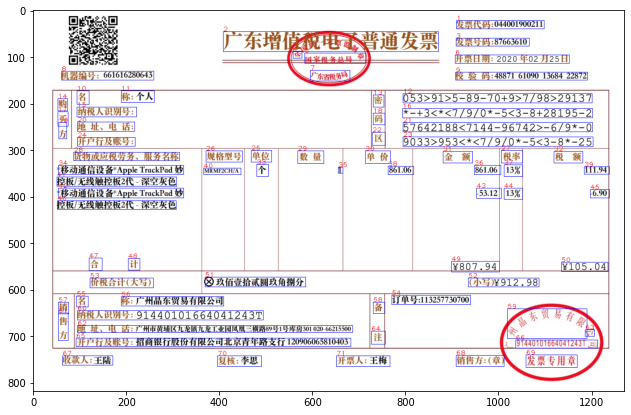

In [10]:
box_imgs, draw_box_img = contours(boxes, scores, img, True)

In [11]:
cv2.imwrite('./data/invoice_box.jpg', cv2.cvtColor(draw_box_img, cv2.COLOR_RGB2BGR))

True

### 2. CRNN + CTC 文本识别

In [12]:
from config import CRNNConfig
from models.crnn import CRNN

In [13]:
from models.decoder import Decoder

In [14]:
cfg = CRNNConfig()

In [15]:
crnn_model = CRNN(cfg.NUM_CLASSES + 2, cfg.INPUT_SHAPE)

In [16]:
crnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 320, 64)       1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 160, 64)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 160, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 80, 128)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 80, 256)        295168    
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 80, 256)        32        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 80, 256)        5

In [19]:
from models.loss import CTCLoss
from models.accuracy import WordACC

In [20]:
pretrain_crnn = tf.keras.models.load_model('./checkpoints/crnn_30.h5', compile=False)

pretrain_crnn.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                      loss=CTCLoss(), 
                      metrics=[WordACC()])

In [21]:
pretrain_crnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  295168    
_________________________________________________________________
batch_normalization (BatchNo multiple                  32        
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  5

In [118]:
pretrain_crnn.save('./tf_models/crnn_ocr', save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./tf_models/crnn_ocr/assets


In [22]:
crnn_model.load_weights('./checkpoints/crnn_30.h5', by_name=True, skip_mismatch=True)

In [44]:
def process_img(img):
    img = img / 255
    img -= 0.5
    img /= 0.5
    
    _h, _w, _ = (32, 320, 3)
    resized_img = tf.image.resize(img, (_h, _w), preserve_aspect_ratio=True)
    
    return tf.image.pad_to_bounding_box(resized_img, 0, 0, _h, _w)

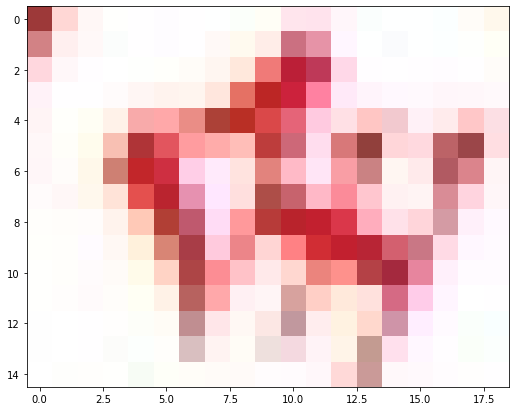

In [67]:
show_img(box_imgs[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


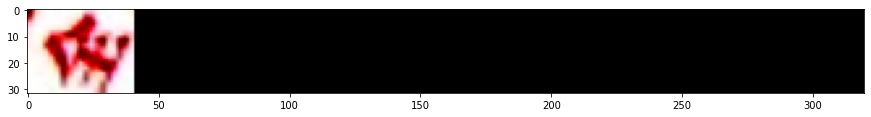

In [68]:
show_img(process_img(box_imgs[3]))

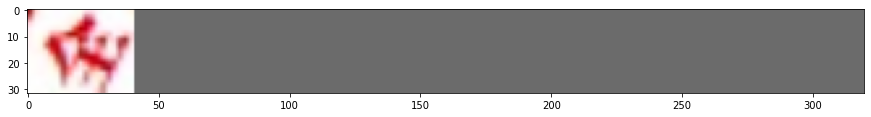

In [69]:
show_img(tf.keras.preprocessing.image.array_to_img(process_img(box_imgs[3])))

In [117]:

cv2.imwrite('./data/box_img64.jpg', cv2.cvtColor(box_imgs[64], cv2.COLOR_BGR2RGB))

True

In [24]:
with open(CRNNConfig.TABLE_PATH, 'r', encoding='utf-8') as f:
    inv_table = [char.strip() for char in f]
    inv_table.append(' ')

decoder = Decoder(inv_table)

In [78]:
def predict_result(model, imgs):
    inputs = []
    
    for img in imgs:
        test_img = np.array(img)
        test_input = process_img(img)
        inputs.append(test_input)

    per_results = model.predict(np.array(inputs))
    print(per_results.shape)
    per_txts = decoder.decode(per_results)
    
    return per_txts

In [119]:
inputs = []

for img in box_imgs[0:1]:
    test_img = np.array(img)
    test_input = process_img(img)
    inputs.append(test_input)

pre_results = pretrain_crnn.predict(np.array(inputs))

In [120]:
pre_results.shape

(1, 81, 5531)

In [113]:
n, h, w = pre_results.shape
for k in range(n): 
    for i in range(h):
        idx = np.argmax(pre_results[k][i])
        if idx <= len(inv_table) - 1:
            print(inv_table[idx], end='')
    print()

发票代码:0440019002111


In [97]:
inv_table[3332]

't'

In [100]:
box_texts = predict_result(pretrain_crnn, box_imgs[4:5])

(1, 81, 5531)


In [101]:
box_texts

['国家税务总局整']

In [27]:
box_texts2 = predict_result(crnn_model, box_imgs)

In [28]:
box_texts

['发票代码:044001900211',
 '广东增税电心普通发票',
 '发票号码:87663610',
 '178',
 '国家税务总局整',
 '开票日期2020年02月25日',
 '广东省税务同',
 '机器编号:661616280643',
 '校验码48871610901368422872',
 '名',
 '称:个人',
 '053915-89-70+97/9829137',
 '密',
 '购',
 '纳税人识别号:',
 '*十3<*<719/0*-5<3-8+28195-2',
 '买',
 '码',
 '方',
 '地址、电话:',
 '576421887144-96742>-6/9*-0',
 '区',
 '9033953<*<719/0-5<3-8*-25',
 '开户行及账号:',
 '单位',
 '规格型号',
 '税率',
 '货物或应税劳务、服务名称',
 '数量',
 '单价',
 '金额',
 '税额',
 '个',
 '移动通信设备*AppleTrackPad妙',
 '1',
 '861.06',
 '13%',
 '861.06',
 '111.94',
 'MRMF2CH/A',
 '控板/无线触控板2代深空灰色',
 '移动通信设备*AppleTrackPad妙',
 '-53.12',
 '13',
 '-6.90',
 '控板/无线触控板2代深空灰色',
 '合',
 '计',
 '￥807.94',
 '￥105.04',
 '玖佰壹拾贰圆玖角捌分',
 '(小写￥912.98',
 '价税合计(大写)',
 '订单号:113257730700',
 '名',
 '称:广州晶东贸易有限公司',
 '销',
 '备',
 'W有限限有限',
 '纳税人识别号:91440101664041243T',
 '',
 '地址。电话广州市黄埔区九龙镇九龙工业园风凰三横路号1号库房30102066215500',
 'V',
 '注',
 '开户行及账号:招商银行股份有限公司北京青年路行120906065810403',
 '91440101664041243T马',
 '收款人:王陆',
 '销售章)',
 '发票专用章',
 '复核:李思',
 '开票人:王梅']

In [29]:
box_texts2[0], box_texts[0]

('', '发票代码:044001900211')

In [30]:
from utils.rectangle import get_rects, is_intersect, solve_conincide

In [31]:
invoice_img = cv2.imread('./data/test4.jpg')
invoice_img = cv2.cvtColor(invoice_img, cv2.COLOR_RGB2BGR)

rects = get_rects(invoice_img)

In [33]:
def merge_rects(rects, direct='row'):
    rects_arr = np.array(rects)
    x = np.min(rects_arr[:, 0])
    y = np.min(rects_arr[:, 1])
    if direct == 'row':
        w = np.sum(rects_arr[:, 2])
        h = np.min(rects_arr[:, 3])
    elif direct == 'column':
        w = np.min(rects_arr[:, 2])
        h = np.sum(rects_arr[:, 3])
    else:
        w = np.sum(np.unique(rects_arr[:, 2]))
        h = np.sum(np.unique(rects_arr[:, 3]))
    
    return x, y, w, h

In [34]:
def loc_box_texts(rect, boxes, h=0.9):
    loc_texts = []
    for i, box in enumerate(reversed(boxes)):
        x1, y1, w1, h1 = cv2.boundingRect(np.array(box))
        x2, y2, w2, h2 = rect
        
        conin_prec = solve_conincide((x1, y1, x1 + w1, y1 + h1), (x2, y2, x2 + w2, y2 + h2))
        if conin_prec > h:
            loc_texts.append(box_texts[i])
    return loc_texts

In [35]:
# 发票类型 
invoice_type_rect = merge_rects(rects[2:9])
invoice_type = loc_box_texts(invoice_type_rect, boxes)

invoice_type

['广东增税电心普通发票', '178']

In [79]:
# 发票代码，发票号码， 开票日期，校验码
invoice_info_rect = merge_rects(rects[8:11] + rects[19:22], direct='multi')
invoice_info = loc_box_texts(invoice_info_rect, boxes)

invoice_info

['发票代码:044001900211',
 '发票号码:87663610',
 '开票日期2020年02月25日',
 '校验码48871610901368422872']

In [80]:
# 名称，纳税人识别号，地址电话，开户行及账号
custom_info = loc_box_texts(rects[23], boxes)
custom_info

['名', '称:个人', '纳税人识别号:', '地址、电话:', '开户行及账号:']

In [81]:
# 密码区
pwd_rect = merge_rects(rects[29:33])
pwd_block = loc_box_texts(pwd_rect, boxes)

pwd_block

['053915-89-70+97/9829137',
 '*十3<*<719/0*-5<3-8+28195-2',
 '576421887144-96742>-6/9*-0',
 '9033953<*<719/0-5<3-8*-25']

In [82]:
# 货物或应balabala...
goods_rect = merge_rects(rects[33:35])
goods_info = loc_box_texts(goods_rect, boxes)

goods_info

['货物或应税劳务、服务名称',
 '移动通信设备*AppleTrackPad妙',
 '控板/无线触控板2代深空灰色',
 '移动通信设备*AppleTrackPad妙',
 '控板/无线触控板2代深空灰色',
 '合',
 '计']

In [83]:
# 规格型号
type_size_rect = rects[35]
type_size_info = loc_box_texts(type_size_rect, boxes)

type_size_info

['规格型号', 'MRMF2CH/A']

In [84]:
# 单位
unit_info = loc_box_texts(rects[36], boxes)

unit_info

['单位', '个']

In [85]:
# 数量
num_info = loc_box_texts(rects[37], boxes)
num_info

['数量', '1']

In [86]:
# 单价
price_rect = merge_rects(rects[38:41])
price_info = loc_box_texts(price_rect, boxes)
price_info

['单价', '861.06']

In [87]:
# 金额
amount_info = loc_box_texts(rects[41], boxes)
amount_info

['金额', '861.06', '-53.12']

In [88]:
# 税率
tax_rate_info = loc_box_texts(rects[42], boxes)
tax_rate_info

['税率', '13%', '13']

In [89]:
# 税额
tax_rate_mount = loc_box_texts(rects[43], boxes)
tax_rate_mount

['税额', '111.94', '-6.90']

In [90]:
# 价税合计
total_amount = loc_box_texts(merge_rects(rects[52:55]), boxes)
total_amount

['(小写￥912.98']

In [91]:
# 销售方名称、纳税人识别号、地址电话、开户行及账号
shopper_rect = merge_rects(rects[56:61])
shopper_info = loc_box_texts(shopper_rect, boxes)
shopper_info

['名',
 '称:广州晶东贸易有限公司',
 '纳税人识别号:91440101664041243T',
 '地址。电话广州市黄埔区九龙镇九龙工业园风凰三横路号1号库房30102066215500',
 '开户行及账号:招商银行股份有限公司北京青年路行120906065810403']

(814, 0, 421, 171)


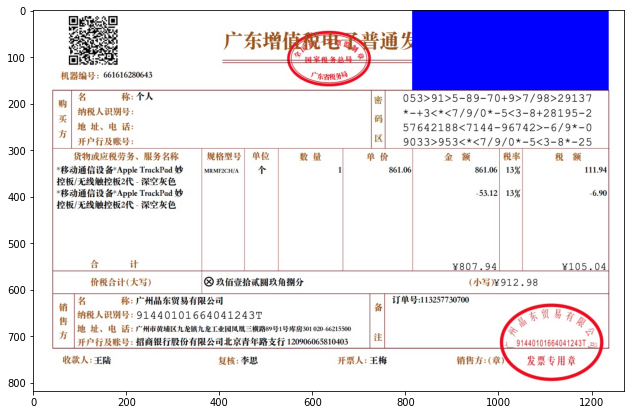

In [67]:
x, y, w, h = b_rect = merge_rects(rects[8:11] + rects[19:22], direct='multi')
print(b_rect)

rects_img = img.copy()

cv2.rectangle(rects_img, (x, y), (x+w, y+h), (0, 0, 255), -1)

show_img(rects_img)
